In [1]:
from __future__ import division, print_function
# turn off all Anaconda warnings
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import math
import pickle
#pip install tqdm
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
#import glob
import collections
from tqdm.auto import tqdm
from collections import Counter
from time import time

# WEEK 2

### Часть 1. Каковы длины (число сессий) новых 16 разреженных матриц?

In [2]:
import scipy.sparse as sps

In [3]:
PATH_TO_DATA = 'capstone_user_identification'

In [4]:
path_3 = os.path.join(PATH_TO_DATA, '3users/*.csv')
path_10 = os.path.join(PATH_TO_DATA, '10users/*.csv')
path_150 = os.path.join(PATH_TO_DATA, '150users/*.csv')

print(path_3)
print(path_10)
print(path_150)

capstone_user_identification\3users/*.csv
capstone_user_identification\10users/*.csv
capstone_user_identification\150users/*.csv


In [5]:
# change data path

path_pkl = os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl')
unpickled_df_3 = pd.read_pickle(path_pkl)
#print(unpickled_df_3)
path_pkl_10 = os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl')
unpickled_df_10 = pd.read_pickle(path_pkl_10)
#print(unpickled_df_10)
path_pkl_150 = os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl')
unpickled_df_150 = pd.read_pickle(path_pkl_150)
#print(unpickled_df_150)

In [7]:
path = os.path.join(PATH_TO_DATA, '3users/*.csv')

stock_files = sorted(glob(path))

path

'capstone_user_identification\\3users/*.csv'

In [6]:
def prepare_sparse_train_set_window(path_to_csv_files, path_to_pkl_files, session_length=10, window_size=10):
    
    stock_files = sorted(glob(path_to_csv_files))
    
    #create dataframe from file
    df = pd.concat((pd.read_csv(file) for file in stock_files), ignore_index=True)
    
    #sorted site
    df_site_dict = path_to_pkl_files
    
    #create number list site
    list_all_site = []
    user_list = []
    user = 1
    for filename in tqdm((stock_files), desc='Loop2'):
        tmp_df = pd.read_csv(filename)
        list_site = []
        for site in tmp_df.site:
            list_site.append(df_site_dict.get(site))
        #print("LEN 1", len(list_site))
        #print("List Site", list_site)
        #multiple_len =  (math.ceil(len(list_site)/session_length))*session_length
        #print(multiple_len)
        #tmp = [0] * (session_length)
        #print(tmp)
        #tmp_little_list = list_site.copy()
        #list_site.extend(tmp)
        #print(len(list_site))
        #print("list site new", list_site)
        count = 0
        for start in range(0, (len(list_site) + window_size), window_size):
            ind_1 = start
            ind_2 = start + session_length
            #print(start)
            if ind_2 <= (len(list_site)-1):
                #print('OK')
                sess = list_site[ind_1 : ind_2]
                #print("SESS", sess)
                #sess.append(user)
                #print(sess)
                list_all_site.append(sess)
                user_list.append(user)
            else:
                if(len(list_site[ind_1:])==0):
                    break
                sess = list_site[ind_1:] + [0 for _ in range(session_length - len(list_site[ind_1:]))]
                #print("SESS2", sess)
                list_all_site.append(sess)
                user_list.append(user)
                #sess.append(user)
        user = user + 1
        
    tmp_arr = np.array(list_all_site)
    row = 0
    width = 0
    rows = []
    cols = []
    data = []

    for arr in tqdm(tmp_arr, desc = "Loop 4"):
        unique, counts = np.unique(arr, return_counts=True)
        #print(dict(zip(unique, counts)))
        #print("next")
        for key, value in dict(zip(unique, counts)).items():
            #print(row, key, value)
            width = width + 1
            if key != 0:
                rows.append(row)
                cols.append(key-1)
                data.append(value)
                #array_new[row][key-1] = value
        row = row + 1
        
    B = sps.coo_matrix((data, (rows, cols))).tocsr()
    return(B, user_list)
        

In [7]:
X_test, y = prepare_sparse_train_set_window(path_3, unpickled_df_3, 5, 3)

In [17]:
#запишу 10 10 для 4 недели для 10 пользователей. в цикле его нет
X_sparse_10, y_10 = prepare_sparse_train_set_window(path_10, unpickled_df_10, 10, 10)

file_name = 'capstone_websites_data_1/X_sparse_%dusers_s%d_w%d.pkl' % (10, 10, 10)
with open(file_name, 'wb') as fp:
    pickle.dump(X_sparse_10, fp)
file_name = 'capstone_websites_data_1/y_%dusers_s%d_w%d.pkl' % (10, 10, 10)
with open(file_name,'wb') as fp:
    pickle.dump(y_10, fp)

In [18]:
#запишу 10 10 для 4 недели для 150 пользователей, в цикле его нет
X_sparse_150, y_150 = prepare_sparse_train_set_window(path_150, unpickled_df_150, 10, 10)

file_name = 'capstone_websites_data_1/X_sparse_%dusers_s%d_w%d.pkl' % (150, 10, 10)
with open(file_name, 'wb') as fp:
    pickle.dump(X_sparse_150, fp)
file_name = 'capstone_websites_data_1/y_%dusers_s%d_w%d.pkl' % (150, 10, 10)
with open(file_name,'wb') as fp:
    pickle.dump(y_150, fp)

Запустите созданную функцию 16 раз с помощью циклов по числу пользователей num_users (10 или 150), значениям параметра session_length (15, 10, 7 или 5) и значениям параметра window_size (10, 7 или 5). Сериализуйте все 16 разреженных матриц (обучающие выборки) и векторов (метки целевого класса – ID пользователя) в файлы X_sparse_{num_users}users_s{session_length}_w{window_size}.pkl и y_{num_users}users_s{session_length}_w{window_size}.pkl.

Чтоб убедиться, что мы все далее будем работать с идентичными объектами, запишите в список data_lengths число строк во всех полученных рареженных матрицах (16 значений). Если какие-то будут совпадать, это нормально (можно сообразить, почему).

На моем ноутбуке этот участок кода отработал за 26 секунд, хотя понятно, что все зависит от эффективности реализации функции prepare_sparse_train_set_window и мощности используемого железа. И честно говоря, моя первая реализация была намного менее эффективной (34 минуты), так что тут у Вас есть возможность оптимизировать свой код.

In [13]:
#%%time
import itertools

t_start = time()

data_lengths = []
user_tmp=[]

for num_users in [10, 150]:
    for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
        if (window_size <= session_length) and ((window_size, session_length) != (10, 10)):
            if num_users == 10:
                path = os.path.join(PATH_TO_DATA, '10users/*.csv')
                unpickled_df = pd.read_pickle(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'))
            else:
                path = os.path.join(PATH_TO_DATA, '150users/*.csv')
                unpickled_df = pd.read_pickle(os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'))    
            print("NUM USER = ", num_users, " Window Size = ", window_size, " Session Length = ", session_length)
            X_sparse, y = prepare_sparse_train_set_window(path, unpickled_df, session_length, window_size)
            data_lengths.append(X_sparse.shape[0])
            user_tmp.append(len(y))
            print(len(y))
            
            
            
            file_name = 'capstone_websites_data_1/X_sparse_%dusers_s%d_w%d.pkl' % (num_users, session_length, window_size)
            with open(file_name, 'wb') as fp:
                pickle.dump(X_sparse, fp)
            file_name = 'capstone_websites_data_1/y_%dusers_s%d_w%d.pkl' % (num_users, session_length, window_size)
            with open(file_name,'wb') as fp:
                pickle.dump(y, fp)
                
            data_lengths.append(X_sparse.shape[0])
            
            print(data_lengths)

print("Time elapse: %lf" % (time() - t_start))

NUM USER =  10  Window Size =  10  Session Length =  15



14061
[14061, 14061]
NUM USER =  10  Window Size =  7  Session Length =  15



20087
[14061, 14061, 20087, 20087]
NUM USER =  10  Window Size =  7  Session Length =  10



20087
[14061, 14061, 20087, 20087, 20087, 20087]
NUM USER =  10  Window Size =  7  Session Length =  7



20087
[14061, 14061, 20087, 20087, 20087, 20087, 20087, 20087]
NUM USER =  10  Window Size =  5  Session Length =  15



28118
[14061, 14061, 20087, 20087, 20087, 20087, 20087, 20087, 28118, 28118]
NUM USER =  10  Window Size =  5  Session Length =  10



28118
[14061, 14061, 20087, 20087, 20087, 20087, 20087, 20087, 28118, 28118, 28118, 28118]
NUM USER =  10  Window Size =  5  Session Length =  7



28118
[14061, 14061, 20087, 20087, 20087, 20087, 20087, 20087, 28118, 28118, 28118, 28118, 28118, 28118]
NUM USER =  10  Window Size =  5  Session Length =  5



28118
[14061, 14061, 20087, 20087, 20087, 20087, 20087, 20087, 28118, 28118, 28118, 28118, 28118, 28118, 28118, 28118]
NUM USER =  150  Window Size =  10  Session Length =  15



137019
[14061, 14061, 20087, 20087, 20087, 20087, 20087, 20087, 28118, 28118, 28118, 28118, 28118, 28118, 28118, 28118, 137019, 137019]
NUM USER =  150  Window Size =  7  Session Length =  15



195712
[14061, 14061, 20087, 20087, 20087, 20087, 20087, 20087, 28118, 28118, 28118, 28118, 28118, 28118, 28118, 28118, 137019, 137019, 195712, 195712]
NUM USER =  150  Window Size =  7  Session Length =  10



195712
[14061, 14061, 20087, 20087, 20087, 20087, 20087, 20087, 28118, 28118, 28118, 28118, 28118, 28118, 28118, 28118, 137019, 137019, 195712, 195712, 195712, 195712]
NUM USER =  150  Window Size =  7  Session Length =  7



195712
[14061, 14061, 20087, 20087, 20087, 20087, 20087, 20087, 28118, 28118, 28118, 28118, 28118, 28118, 28118, 28118, 137019, 137019, 195712, 195712, 195712, 195712, 195712, 195712]
NUM USER =  150  Window Size =  5  Session Length =  15



273957
[14061, 14061, 20087, 20087, 20087, 20087, 20087, 20087, 28118, 28118, 28118, 28118, 28118, 28118, 28118, 28118, 137019, 137019, 195712, 195712, 195712, 195712, 195712, 195712, 273957, 273957]
NUM USER =  150  Window Size =  5  Session Length =  10



273957
[14061, 14061, 20087, 20087, 20087, 20087, 20087, 20087, 28118, 28118, 28118, 28118, 28118, 28118, 28118, 28118, 137019, 137019, 195712, 195712, 195712, 195712, 195712, 195712, 273957, 273957, 273957, 273957]
NUM USER =  150  Window Size =  5  Session Length =  7



273957
[14061, 14061, 20087, 20087, 20087, 20087, 20087, 20087, 28118, 28118, 28118, 28118, 28118, 28118, 28118, 28118, 137019, 137019, 195712, 195712, 195712, 195712, 195712, 195712, 273957, 273957, 273957, 273957, 273957, 273957]
NUM USER =  150  Window Size =  5  Session Length =  5



273957
[14061, 14061, 20087, 20087, 20087, 20087, 20087, 20087, 28118, 28118, 28118, 28118, 28118, 28118, 28118, 28118, 137019, 137019, 195712, 195712, 195712, 195712, 195712, 195712, 273957, 273957, 273957, 273957, 273957, 273957, 273957, 273957]
Time elapse: 184.293905


In [17]:
X_sparse_10users, y_sparse_10users = prepare_sparse_train_set_window(path_10, unpickled_df_10, 10, 10)

In [7]:
X_sparse_10users_15_5, y_sparse_10users_15_5 = prepare_sparse_train_set_window(path_10, unpickled_df_10, 15, 5)

In [20]:
#пришлось выполнить для четвертой недели
with open(os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'), 'wb') as X10_pkl:
    pickle.dump(X_sparse_10users, X10_pkl, protocol=2)

In [21]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)

In [8]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_10users_15_5.pkl'), 'wb') as X10_pkl:
    pickle.dump(X_sparse_10users_15_5, X10_pkl, protocol=2)

In [9]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users_15_5.pkl'), 'rb') as X_sparse_10users_15_5_pkl:
    X_sparse_10users_15_5 = pickle.load(X_sparse_10users_15_5_pkl)

In [10]:
X_sparse_10users_15_5.shape

(28118, 4913)

In [65]:
result =""
for i in data_lengths:
    result = result + str(i)
print(result)

1406120087200872008728118281182811828118137019195712195712195712273957273957273957273957


### Часть 2. Распределено ли нормально число уникальных сайтов в сессии?

In [14]:
PATH_TO_DATA_2 = 'capstone_websites_data'

In [15]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA_2, 'train_data_10users.csv'), 
                       index_col='session_id')

In [16]:
train_df.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
session_id,,,,,,,,,,,
0,192,574,133,3,133,133,3,133,203,133,1
1,415,193,674,254,133,31,393,3305,217,55,1
2,55,3,55,55,5,293,415,333,897,55,1
3,473,3306,473,55,55,55,55,937,199,123,1
4,342,55,5,3307,258,211,3308,2086,675,2086,1


In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14061 entries, 0 to 14060
Data columns (total 11 columns):
site1      14061 non-null int64
site2      14061 non-null int64
site3      14061 non-null int64
site4      14061 non-null int64
site5      14061 non-null int64
site6      14061 non-null int64
site7      14061 non-null int64
site8      14061 non-null int64
site9      14061 non-null int64
site10     14061 non-null int64
user_id    14061 non-null int64
dtypes: int64(11)
memory usage: 1.3 MB


In [18]:
train_df['user_id'].value_counts()

7     2796
3     2204
8     1868
6     1712
9     1643
2     1022
4      802
1      760
5      720
10     534
Name: user_id, dtype: int64

In [19]:
num_unique_sites = [np.unique(train_df.values[i, :-1]).shape[0] 
                    for i in range(train_df.shape[0])]

In [20]:
pd.Series(num_unique_sites).value_counts()

7     2308
6     2197
8     2046
5     1735
9     1394
2     1246
4     1163
3      894
10     651
1      427
dtype: int64

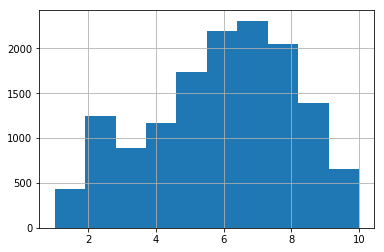

In [23]:
pd.Series(num_unique_sites).hist()

In [24]:
import pylab 
import scipy.stats as stats

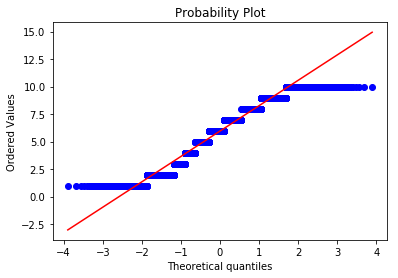

In [25]:
stats.probplot(num_unique_sites, dist="norm", plot=pylab)
pylab.show()

In [26]:
stat, p = stats.shapiro(num_unique_sites)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.955, p=0.000
Sample does not look Gaussian (reject H0)


Верно, распределение не нормально – хвосты тяжелые.

### Часть 3. Каково p-value при проверке гипотезы, что доля случаев, когда пользователь повторно посетил какой-то сайт больше 95%? Ответ 3 знака после запятой.

In [27]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')

In [28]:
len(num_unique_sites)

14061

In [29]:
stats.binom_test(has_two_similar.sum(), has_two_similar.shape[0], 0.95, alternative='greater')

0.02207653769072678

### Часть 4. Каков 95%-доверительный интервал Уилсона для величины из прошлого вопроса? (границы округляются до 3 знаков после запятой).

In [30]:
from statsmodels.stats.proportion import proportion_confint

In [31]:
wilson_interval = proportion_confint(has_two_similar.sum(), has_two_similar.shape[0], method='wilson')
wilson_interval

(0.9501028841411286, 0.9570527377232229)

### Часть 5. Каков 95%-доверительный интервал для средней частоты появления сайта в выборке?

In [83]:
def get_bootstrap_samples(data, n_samples, random_seed=17):
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [84]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, 
                 [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [48]:
stock_files = sorted(glob(path_10))
df = pd.concat((pd.read_csv(file) for file in stock_files), ignore_index=True)

In [49]:
df.head()

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net


In [50]:
sorted_site = dict(collections.OrderedDict(sorted(Counter(df.site).items(), key=lambda kv: kv[1], reverse = True)))

In [71]:
import matplotlib.pyplot as plt

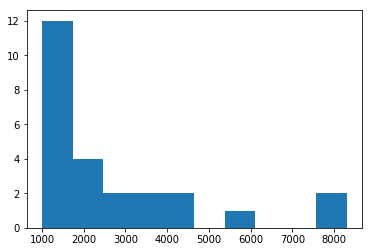

In [79]:
sorted_site_1000 = {}

for key, value in sorted_site.items():
    if value >= 1000:
        sorted_site_1000[key] = value
    
plt.hist(list(sorted_site_1000.values()))
plt.show()
#sorted_site_1000_hist
#sorted_site_1000_hist.hist()

In [85]:
site_freq = list(sorted_site.values())
len(site_freq)

4913

In [100]:
site_mean_scores = list(map(np.mean, get_bootstrap_samples(np.array(site_freq), len(site_freq))))

In [101]:
site_mean_scores

[27.891105231019743,
 24.295135355180133,
 27.0677793608793,
 27.184001628332993,
 32.174638713616936,
 28.17993079584775,
 29.914105434561368,
 27.266028902910644,
 30.302462853653573,
 25.549358843883574,
 27.137187054752697,
 23.657846529615306,
 28.639120700183188,
 26.376144921636474,
 25.916751475676776,
 31.33034805617749,
 25.378790962751882,
 26.273559943008344,
 30.746997761042135,
 42.23020557704051,
 24.951557093425606,
 29.266028902910644,
 33.738652554447384,
 23.868919193975167,
 27.538978221046204,
 21.88133523305516,
 32.11215143496845,
 30.1145939344596,
 32.19112558518217,
 28.189497252188072,
 28.607775290046813,
 31.614288622023203,
 32.64481986566253,
 32.239364950132305,
 31.928963973132504,
 29.522898432729495,
 34.0844697740688,
 30.313861184612254,
 27.044779157337675,
 25.481783024628538,
 25.231223285161814,
 26.410136372888257,
 28.978628129452474,
 27.710360268674943,
 25.704864644819867,
 33.82149399552208,
 26.63199674333401,
 30.5104823936495,
 30.94870

In [102]:
print ("95% confidence interval for the ILEC median repair time:",  stat_intervals(site_mean_scores, 0.05))

95% confidence interval for the ILEC median repair time: [22.51524527 35.76303684]


In [99]:
not_sorted = Counter(df.site)
not_sorted_freq = list(not_sorted.values())
not_sorted_freq[:5]

[88, 23, 119, 5441, 84]

In [103]:
site_mean_scores_not_sort = list(map(np.mean, get_bootstrap_samples(np.array(not_sorted_freq), len(not_sorted_freq))))

In [104]:
print ("95% confidence interval for the ILEC median repair time:",  stat_intervals(site_mean_scores_not_sort, 0.05))

95% confidence interval for the ILEC median repair time: [22.49440261 35.56588642]
